In [ ]:
from pathlib import Path
import os, sys
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Making the reference masks

Reference map tile is `213405`, from both 1965 and 1984. From these maps, all classes were manually annotated by human experts to use as training and validation data. All reference masks are stored as separate files, so we first merge them into a single file that has encoding

1. Fields
2. Marshes
3. Roads
4. Waterways
5. Water bodies

## 1965

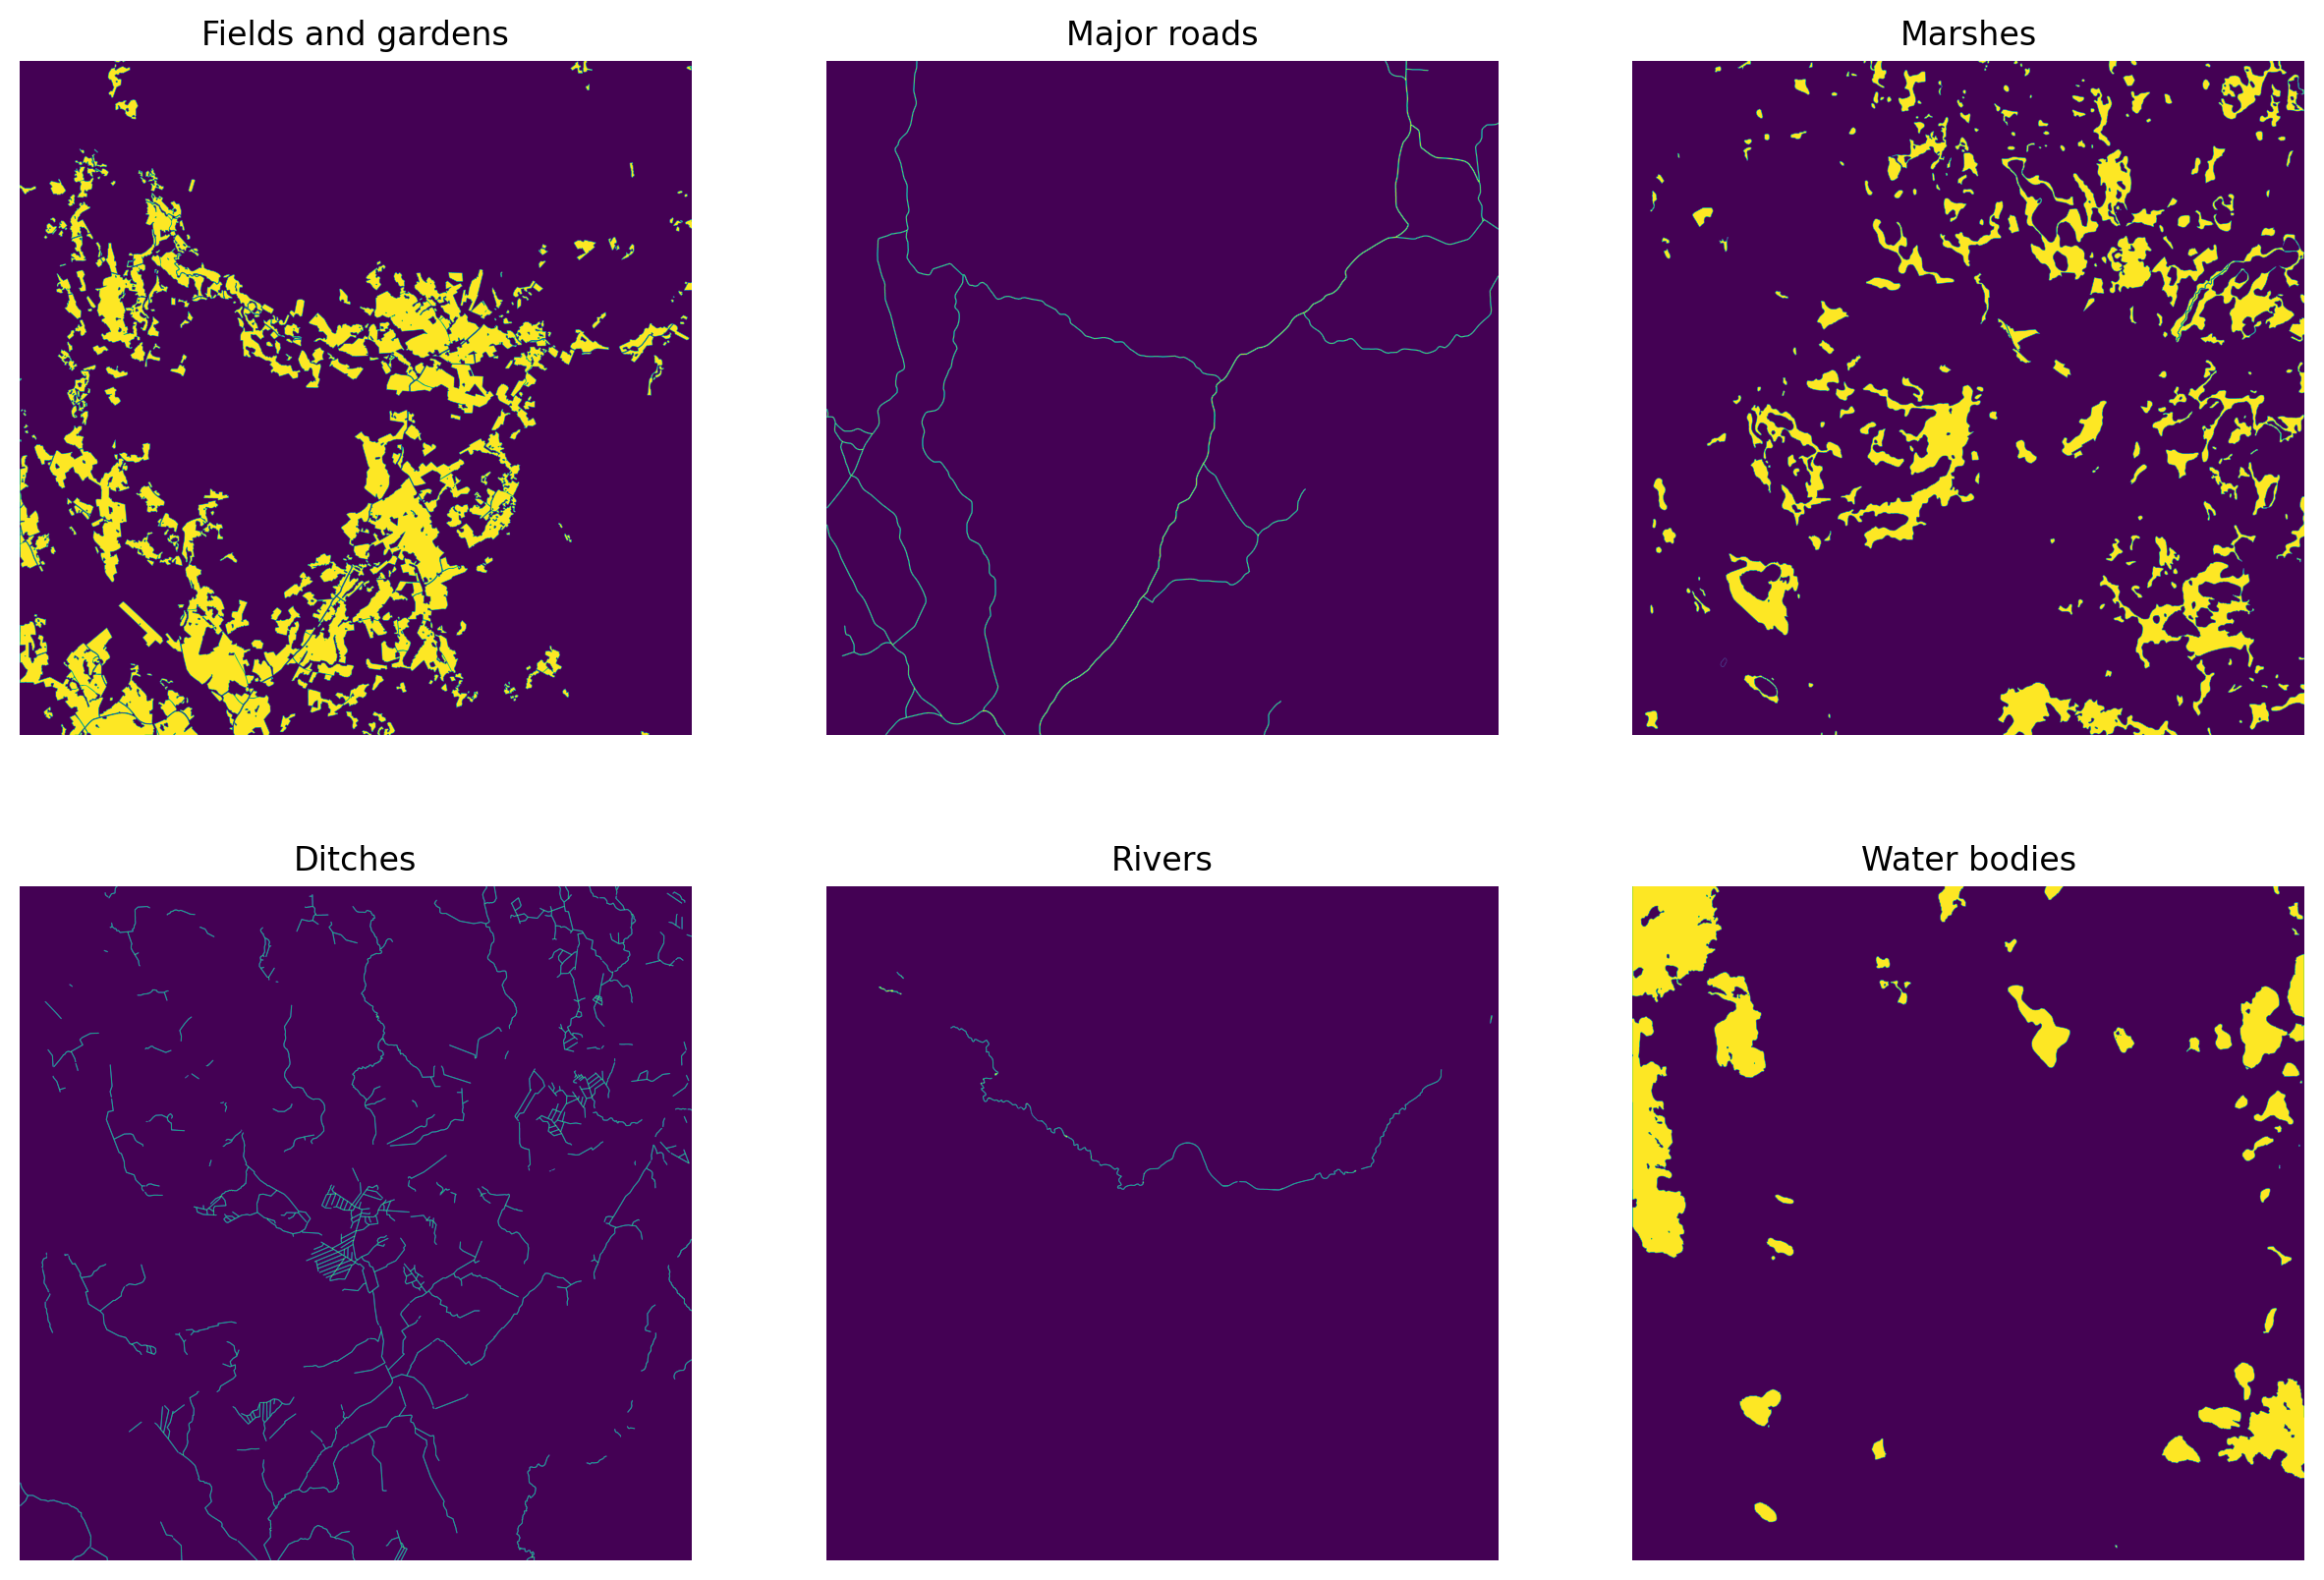

In [ ]:
ref_path = Path('../data/reference_masks')
fields = cv2.imread(str(ref_path/'1965/fields.png'), cv2.IMREAD_UNCHANGED)
water_bodies = cv2.imread(str(ref_path/'1965/lakes.png'), cv2.IMREAD_UNCHANGED)
rivers = cv2.imread(str(ref_path/'1965/rivers.png'), cv2.IMREAD_UNCHANGED)
ditches = cv2.imread(str(ref_path/'1965/ditches.png'), cv2.IMREAD_UNCHANGED)
roads = cv2.imread(str(ref_path/'1965/roads.png'), cv2.IMREAD_UNCHANGED)
marshes = cv2.imread(str(ref_path/'1965/marshes.png'), cv2.IMREAD_UNCHANGED)

waterways = rivers + ditches

fig, axs = plt.subplots(2,3, figsize=(15,10), dpi=200)
for a in axs.flatten(): a.axis('off')
axs[0,0].imshow(fields)
axs[0,0].set_title('Fields and gardens')
axs[0,1].imshow(roads)
axs[0,1].set_title('Major roads')
axs[0,2].set_title('Marshes')
axs[0,2].imshow(marshes)
axs[1,0].imshow(ditches)
axs[1,0].set_title('Ditches')
axs[1,1].imshow(rivers)
axs[1,1].set_title('Rivers')
axs[1,2].imshow(water_bodies)
axs[1,2].set_title('Water bodies')

plt.show()

Stack these into a single image and save it.

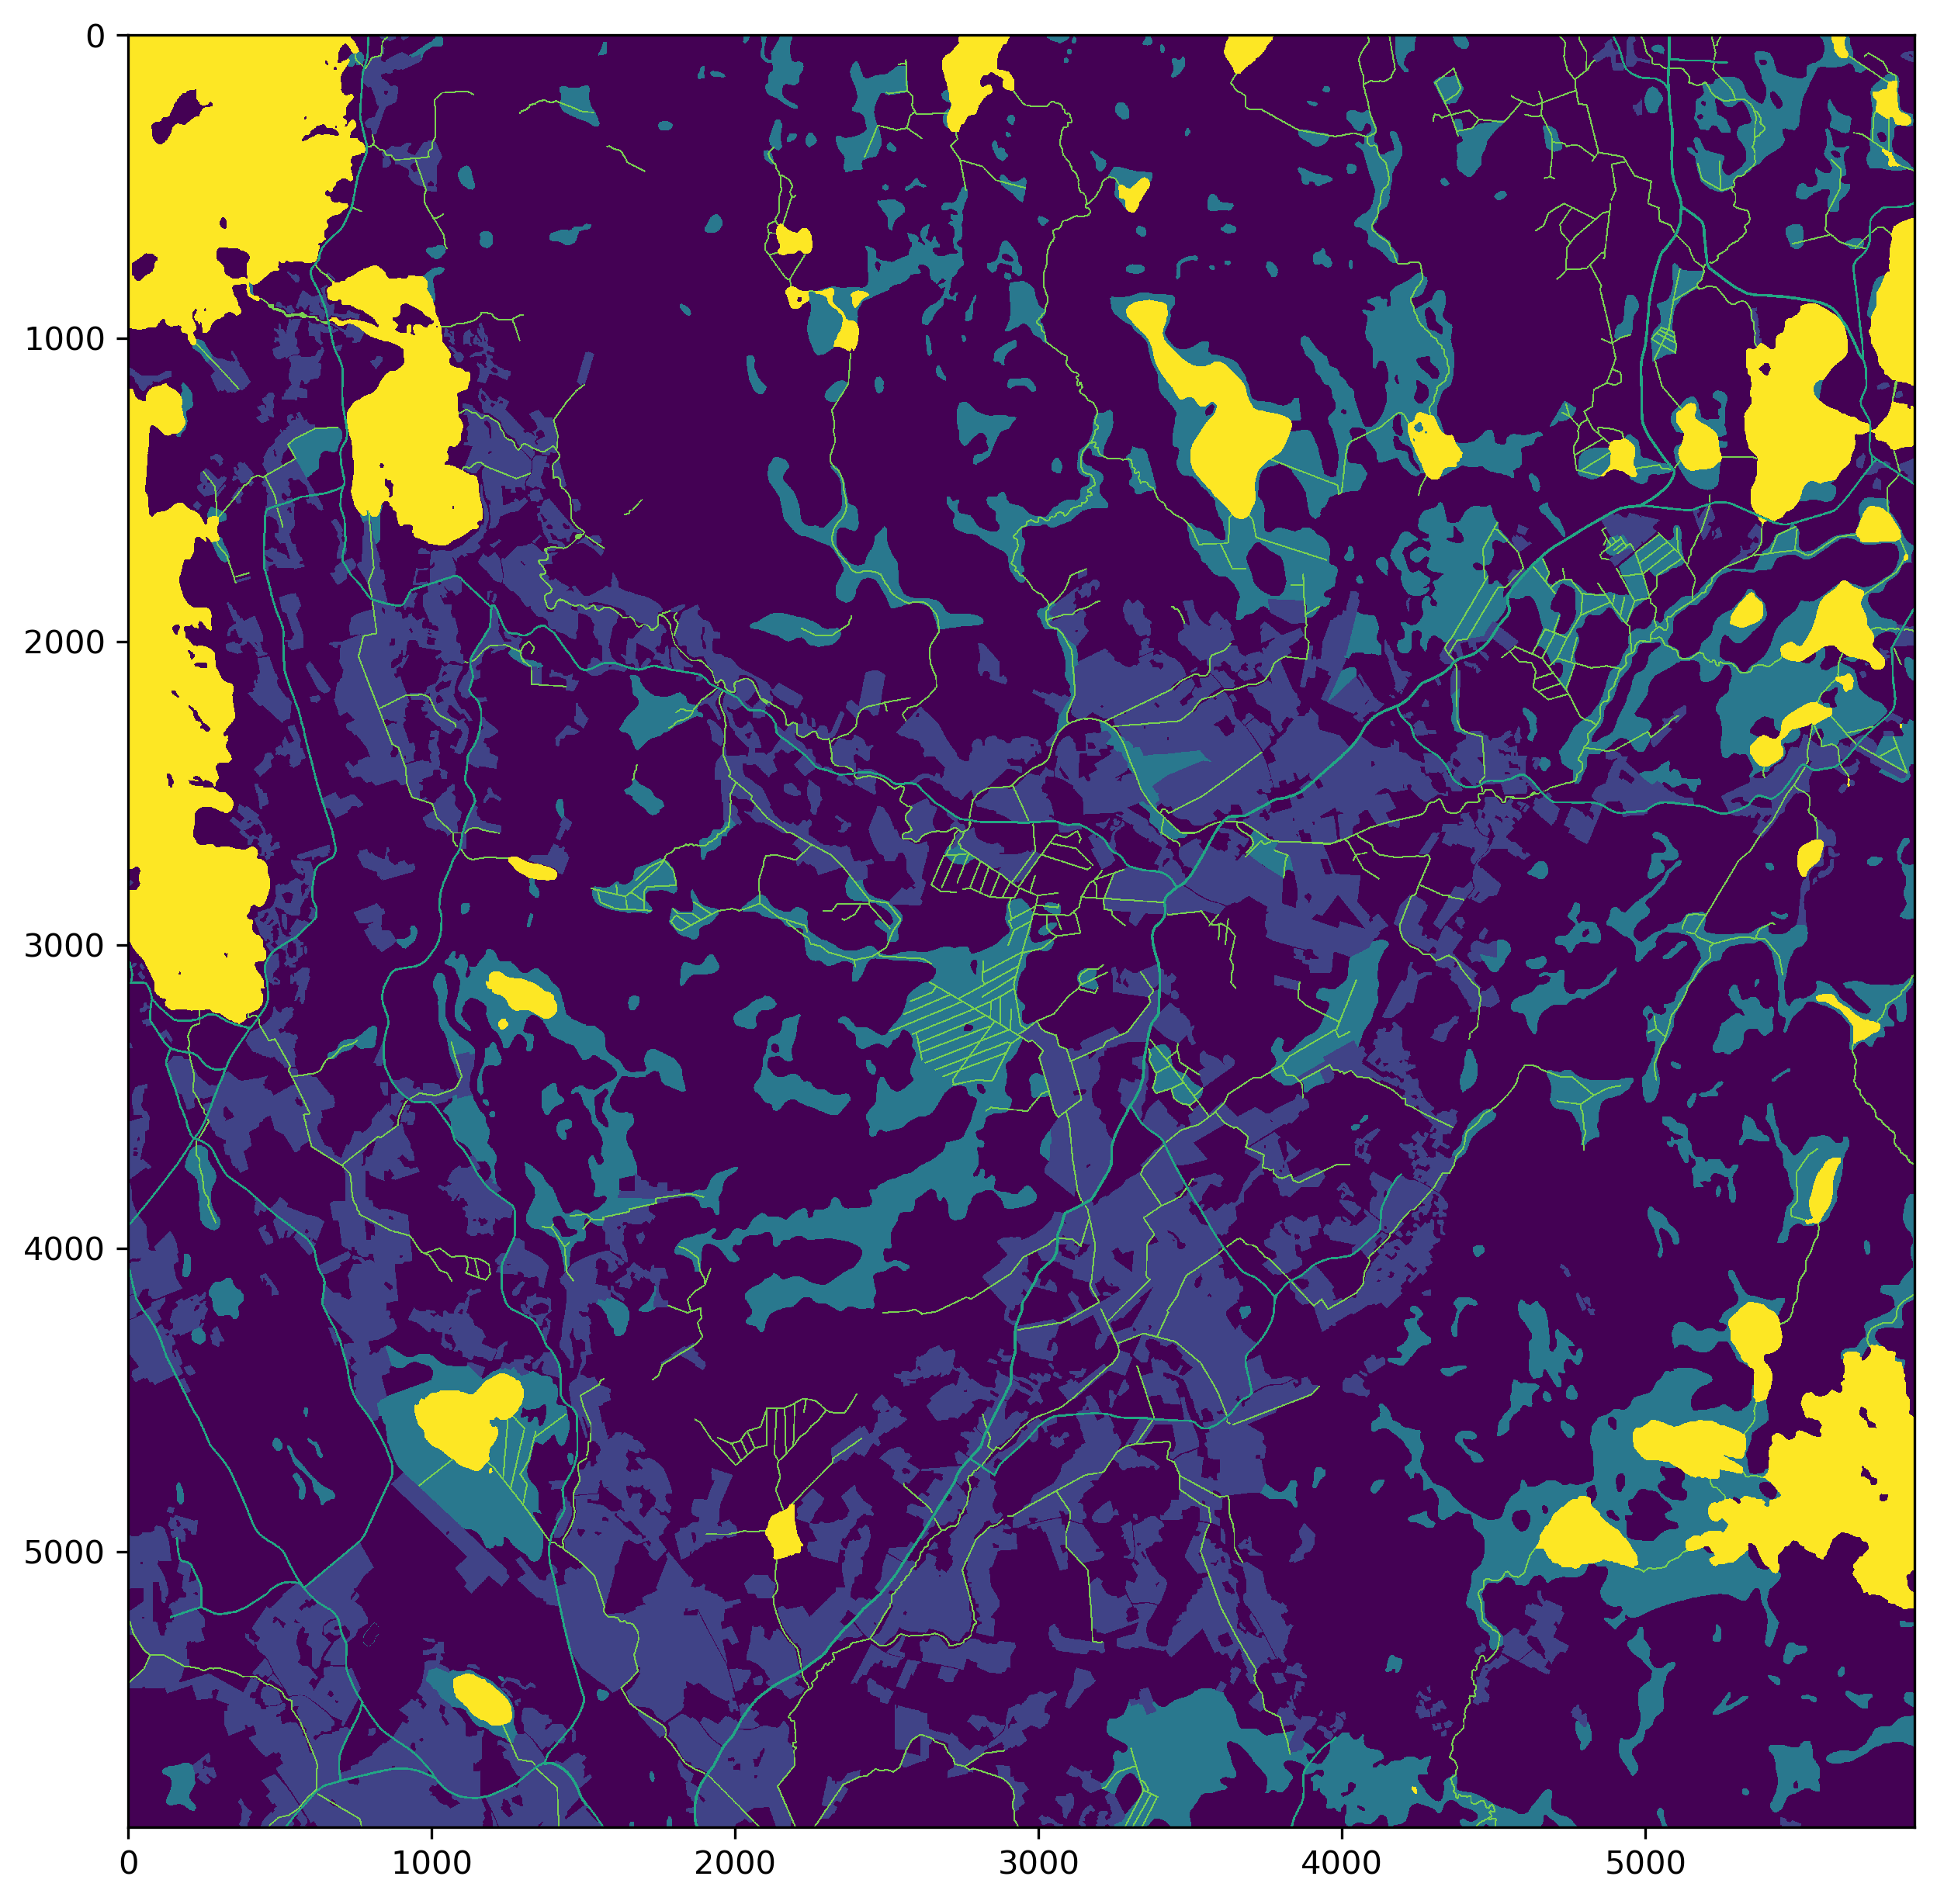

In [ ]:
outim = np.empty((fields.shape), np.uint8)
outim[fields > 0] = 1
outim[marshes > 0] = 2
outim[roads > 0] = 3
outim[waterways > 0] = 4
outim[water_bodies > 0] = 5
fig = plt.figure(figsize=(10,10), dpi=300)
plt.imshow(outim, vmin=0, vmax=5, interpolation='none')
cv2.imwrite(str(ref_path/'combined_mask_1965.png'), outim.astype('uint8'))
plt.show()

## 1984

Do the same for 1984.

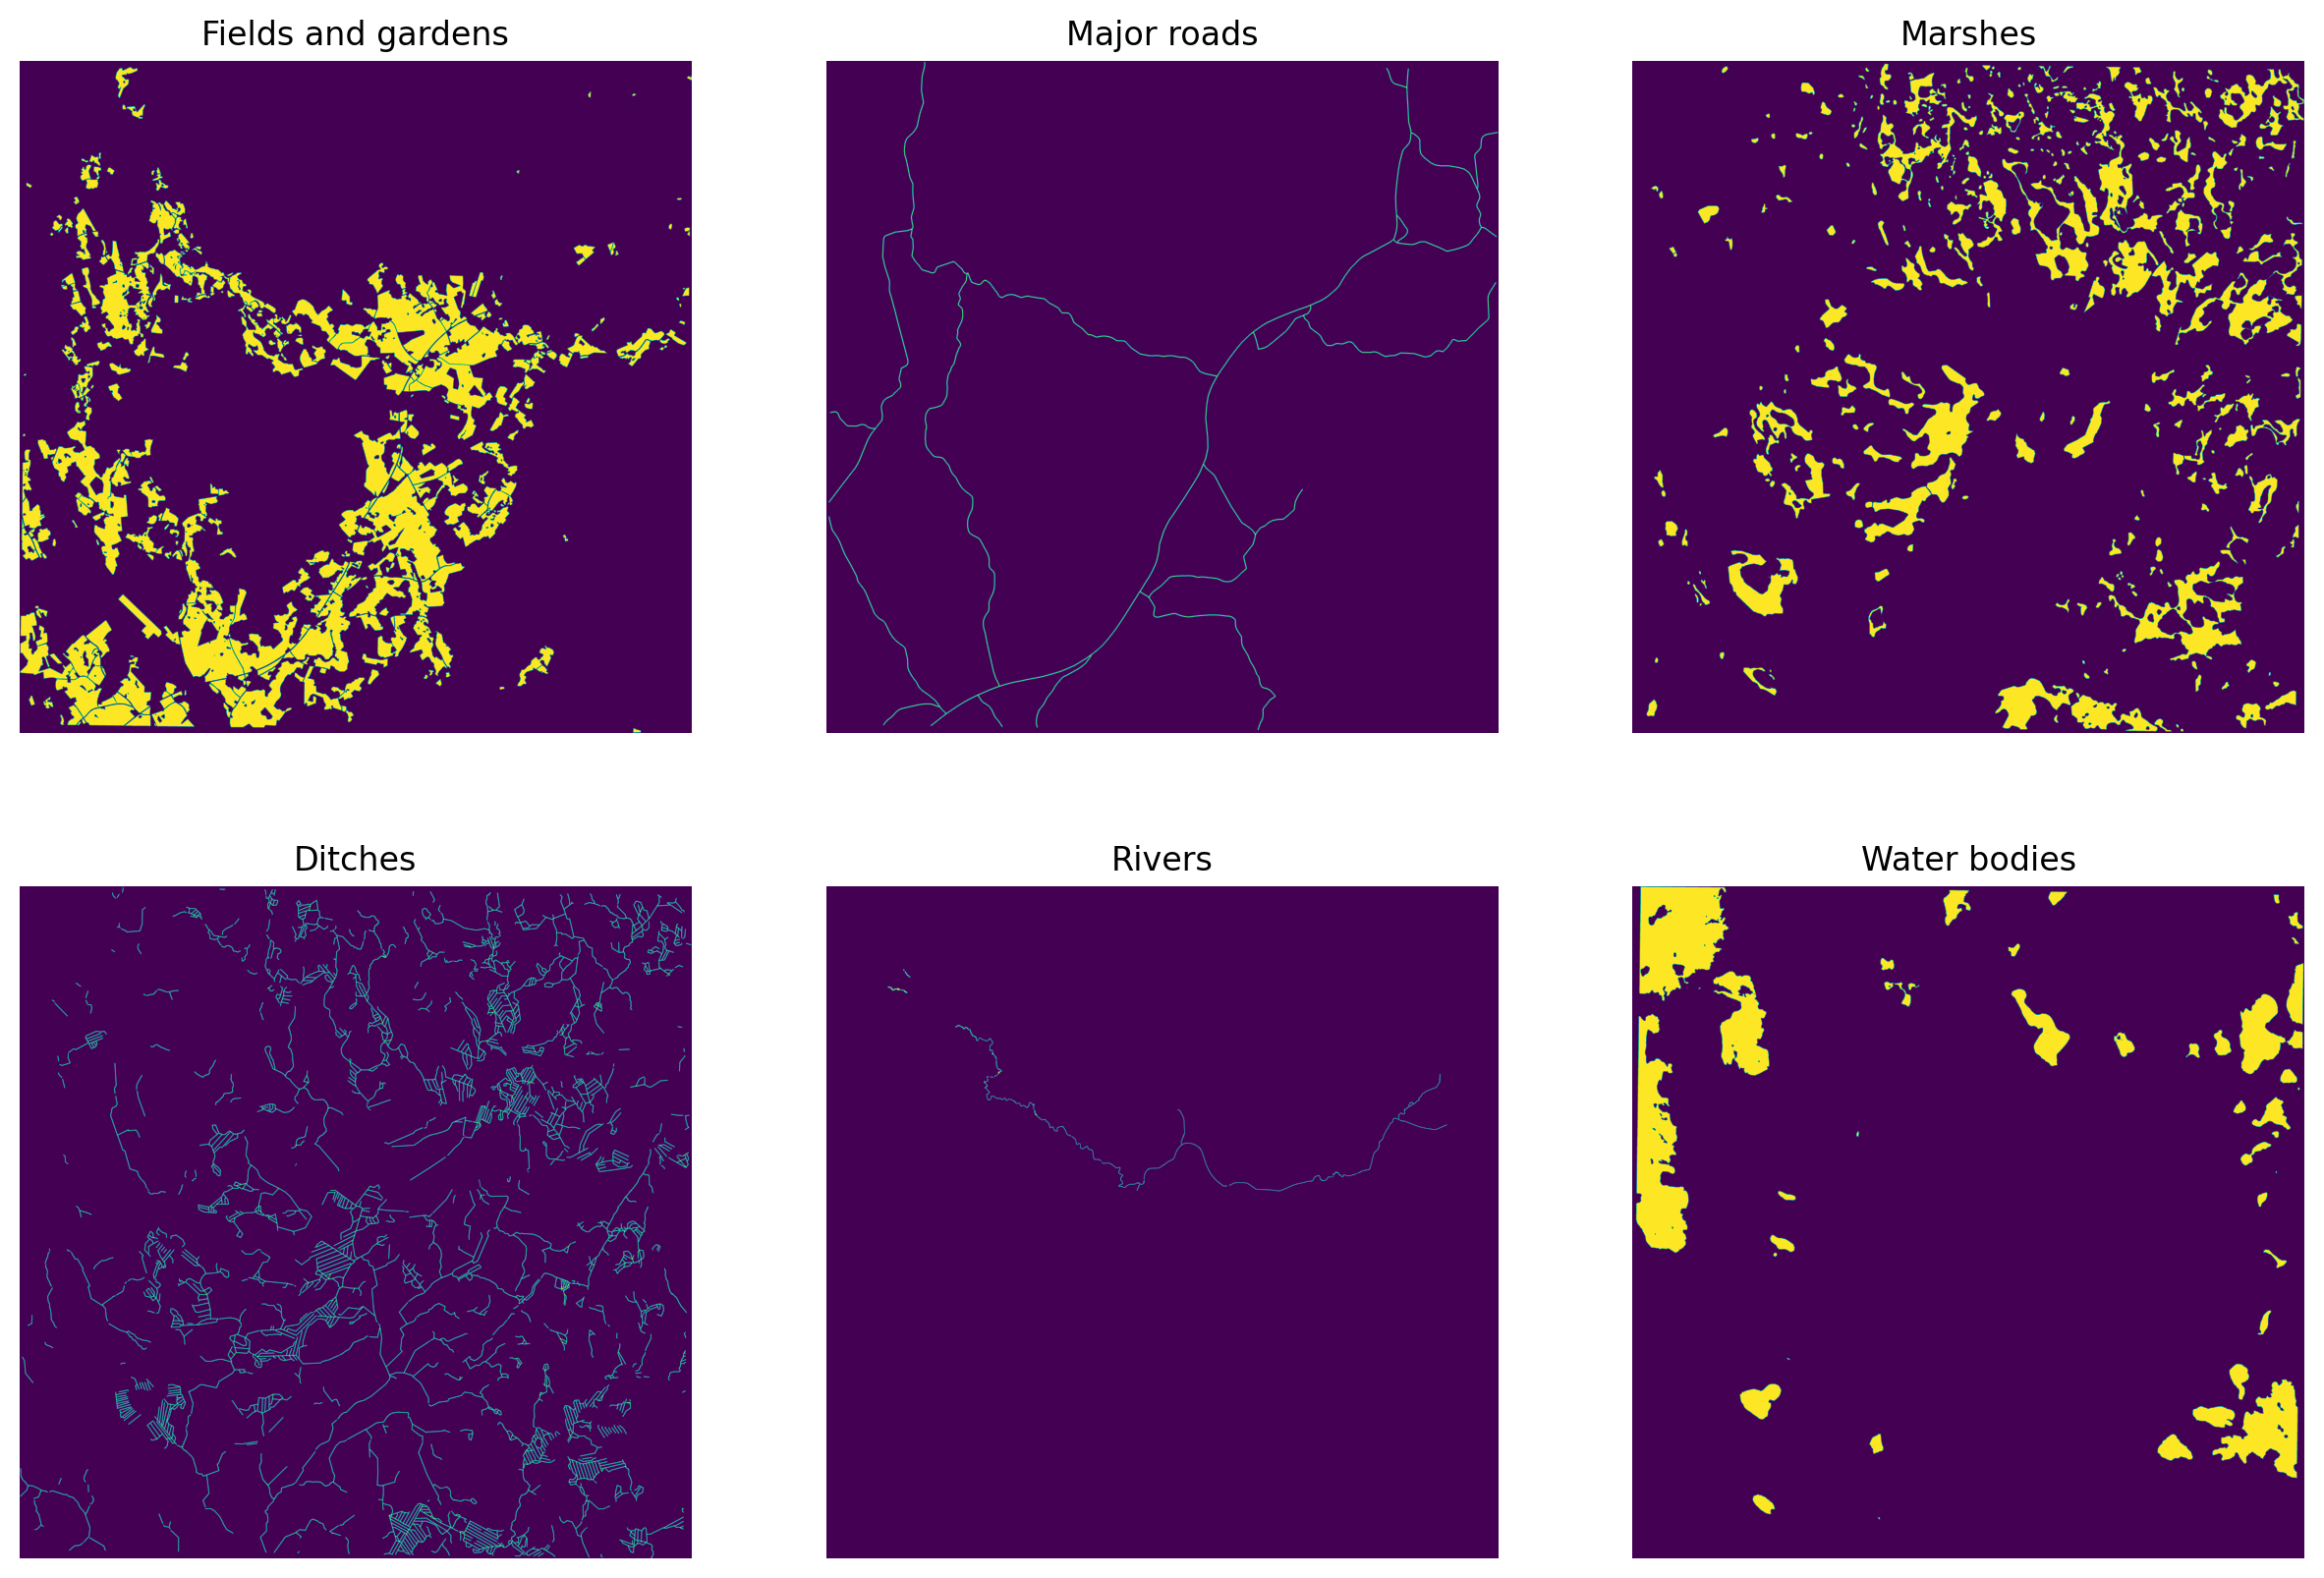

In [ ]:
ref_path = Path('../data/reference_masks')
fields = cv2.imread(str(ref_path/'1984/fields.png'), cv2.IMREAD_UNCHANGED)
water_bodies = cv2.imread(str(ref_path/'1984/lakes.png'), cv2.IMREAD_UNCHANGED)
rivers = cv2.imread(str(ref_path/'1984/rivers.png'), cv2.IMREAD_UNCHANGED)
ditches = cv2.imread(str(ref_path/'1984/ditches.png'), cv2.IMREAD_UNCHANGED)
roads = cv2.imread(str(ref_path/'1984/roads.png'), cv2.IMREAD_UNCHANGED)
marshes = cv2.imread(str(ref_path/'1984/marshes.png'), cv2.IMREAD_UNCHANGED)

waterways = rivers + ditches

fig, axs = plt.subplots(2,3, figsize=(15,10), dpi=200)
for a in axs.flatten(): a.axis('off')
axs[0,0].imshow(fields)
axs[0,0].set_title('Fields and gardens')
axs[0,1].imshow(roads)
axs[0,1].set_title('Major roads')
axs[0,2].set_title('Marshes')
axs[0,2].imshow(marshes)
axs[1,0].imshow(ditches)
axs[1,0].set_title('Ditches')
axs[1,1].imshow(rivers)
axs[1,1].set_title('Rivers')
axs[1,2].imshow(water_bodies)
axs[1,2].set_title('Water bodies')

plt.show()

Stack these into a single mask.

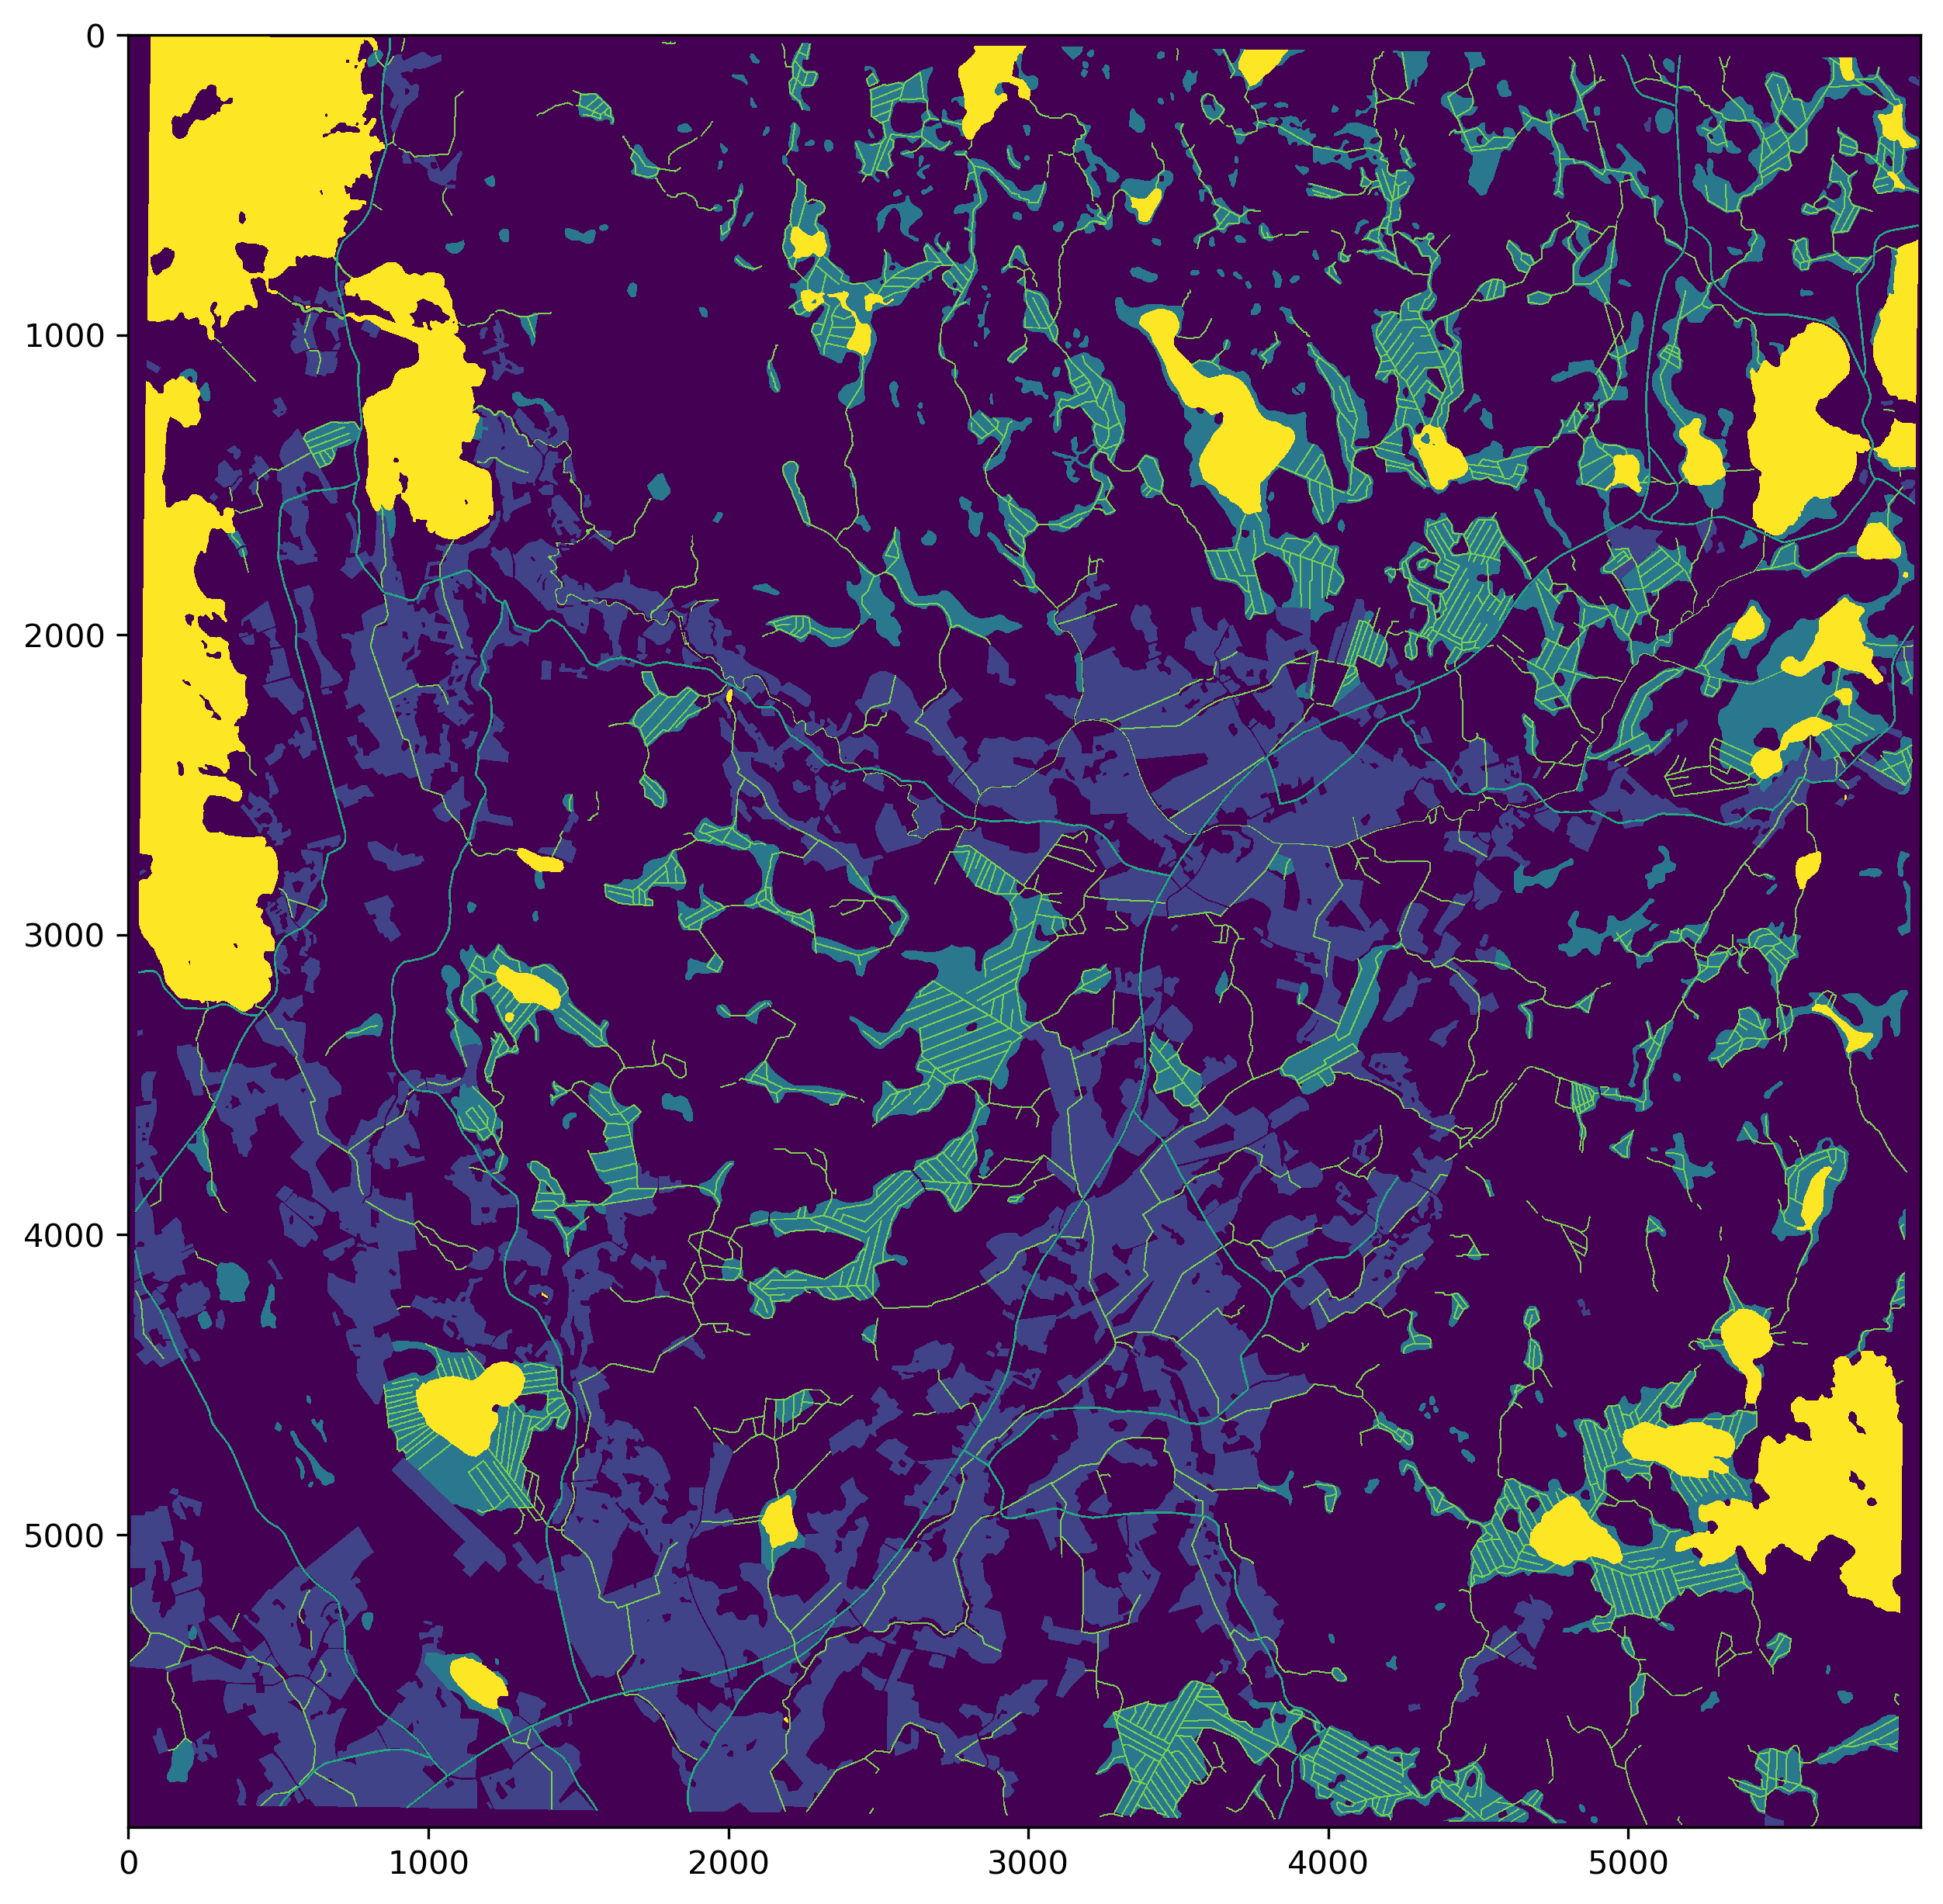

In [ ]:
outim = np.empty((fields.shape), np.uint8)
outim[fields > 0] = 1
outim[marshes > 0] = 2
outim[roads > 0] = 3
outim[waterways > 0] = 4
outim[water_bodies > 0] = 5
fig = plt.figure(figsize=(10,10), dpi=300)
plt.imshow(outim, vmin=0, vmax=5, interpolation='none')
cv2.imwrite(str(ref_path/'combined_mask_1984.png'), outim.astype('uint8'))
plt.show()

## Masks side by side

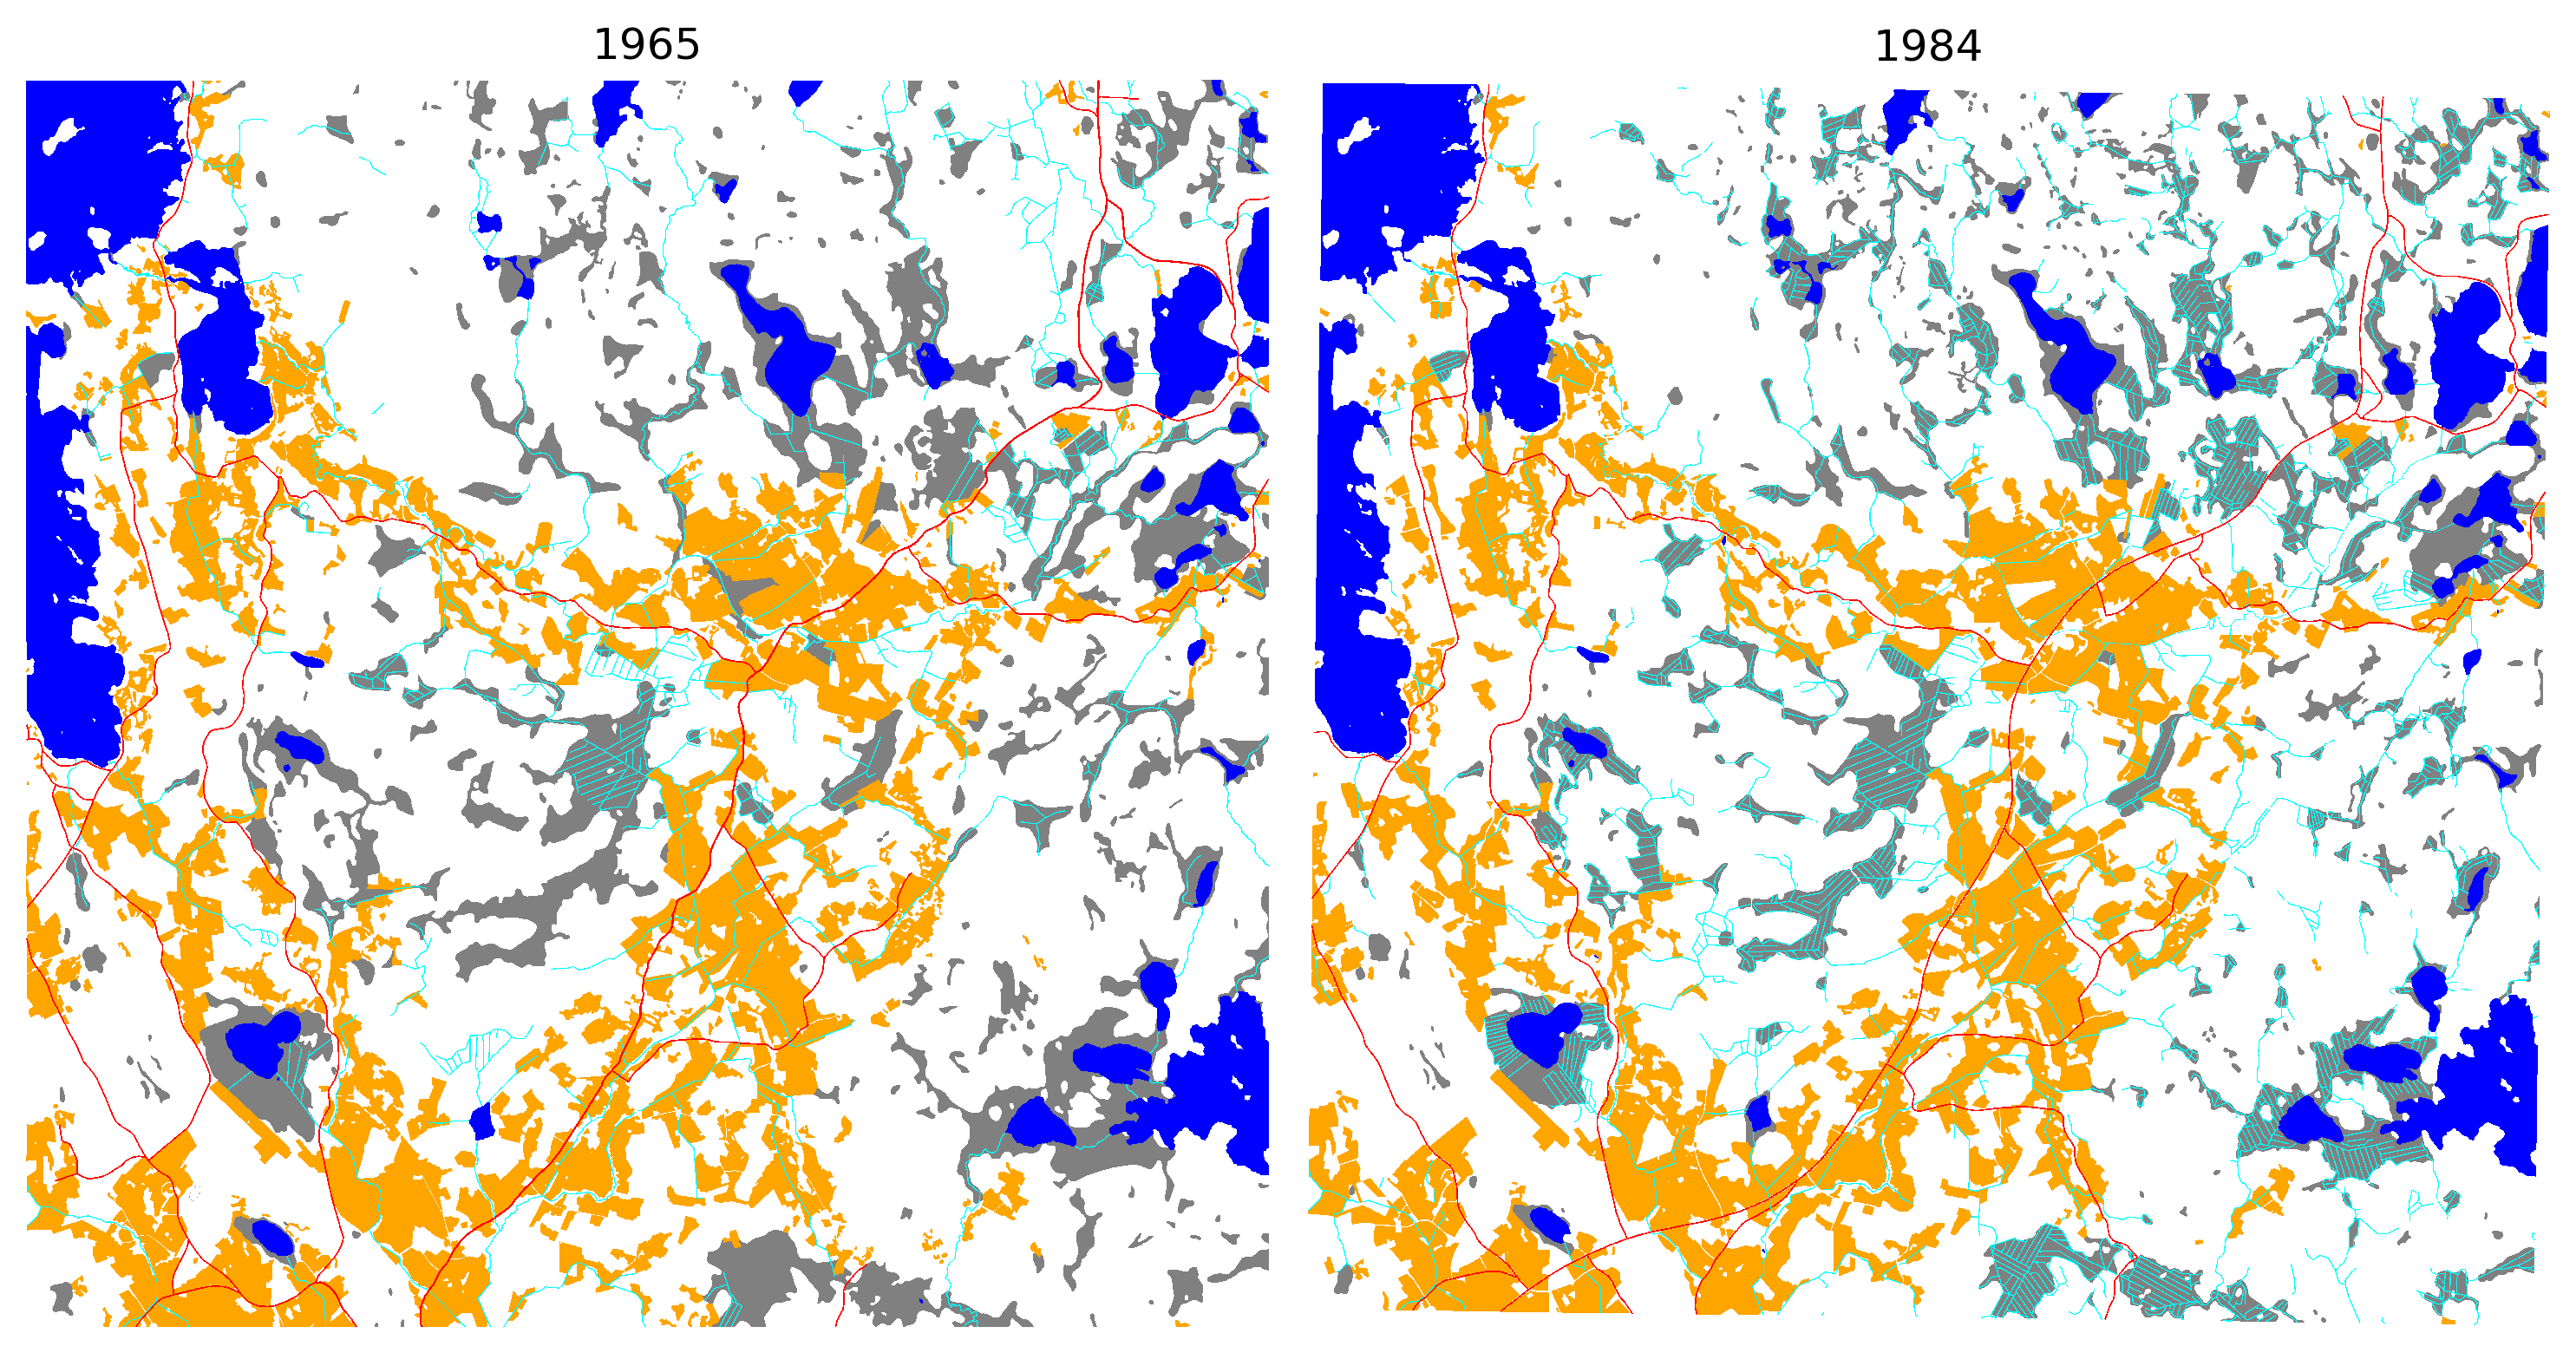

In [ ]:
from matplotlib import colors
cmap = colors.ListedColormap(['white', 'orange', 'grey', 'red', 'cyan', 'blue'])
bounds=[0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)
mask_65 = cv2.imread(str(ref_path/'combined_mask_1965.png'),0)
mask_84 = cv2.imread(str(ref_path/'combined_mask_1984.png'),0)
fig, axs = plt.subplots(1,2, figsize=(10,6), dpi=300)
for a in axs: a.axis('off')
axs[0].imshow(mask_65, vmin=0, vmax=5, cmap=cmap, interpolation='none')
axs[0].set_title('1965')
axs[1].imshow(mask_84, vmin=0, vmax=5, cmap=cmap, interpolation='none')
axs[1].set_title('1984')
plt.tight_layout()
plt.show()

# Georeference masks

Use the corresponding cropped ground control points to georeference these masks, so that tiling and demosaicing is easier.

In [ ]:
from osgeo import gdal
from pyproj import CRS, Transformer
import pandas as pd

In [ ]:
gcps = pd.read_csv(f'../data/gcps/cropped/213405_1965.jpg.points')
in_crs = CRS('EPSG:4326')
out_crs = CRS('EPSG:3067')
transformer = Transformer.from_crs(in_crs, out_crs, always_xy=True)
gcp_list = []
for row in gcps.itertuples():
    tfmd_x, tfmd_y = transformer.transform(row.mapX, row.mapY)
    gcp_list.append(gdal.GCP(tfmd_x, tfmd_y, 1, row.pixelX, row.pixelY))

translate_kwargs = {
    'GCPs': gcp_list,
    'format': 'GTIFF',
    'bandList': [1],
    'outputType': gdal.gdalconst.GDT_Int16
}

inpath = '../data/reference_masks/combined_mask_1965.png'
outpath = '../data/reference_masks/combined_mask_1965.tif'

gdal.Translate(outpath, inpath, **translate_kwargs)
gdal.Warp(outpath, outpath, options='-r near -tps -co COMPRESS=LZW -t_srs EPSG:3067')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *'> >

In [ ]:
gcps = pd.read_csv(f'../data/gcps/cropped/213405_1984.jpg.points')
in_crs = CRS('EPSG:4326')
out_crs = CRS('EPSG:3067')
transformer = Transformer.from_crs(in_crs, out_crs, always_xy=True)
gcp_list = []
for row in gcps.itertuples():
    tfmd_x, tfmd_y = transformer.transform(row.mapX, row.mapY)
    gcp_list.append(gdal.GCP(tfmd_x, tfmd_y, 1, row.pixelX, row.pixelY))

translate_kwargs = {
    'GCPs': gcp_list,
    'format': 'GTIFF',
    'bandList': [1],
    'outputType': gdal.gdalconst.GDT_Int16
}

inpath = '../data/reference_masks/combined_mask_1984.png'
outpath = '../data/reference_masks/combined_mask_1984.tif'

gdal.Translate(outpath, inpath, **translate_kwargs)
gdal.Warp(outpath, outpath, options='-r near -tps -co COMPRESS=LZW -t_srs EPSG:3067')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *'> >

After georeferencing the masks are correctly aligned.

In [ ]:
import rasterio as rio
import rasterio.plot as rioplot

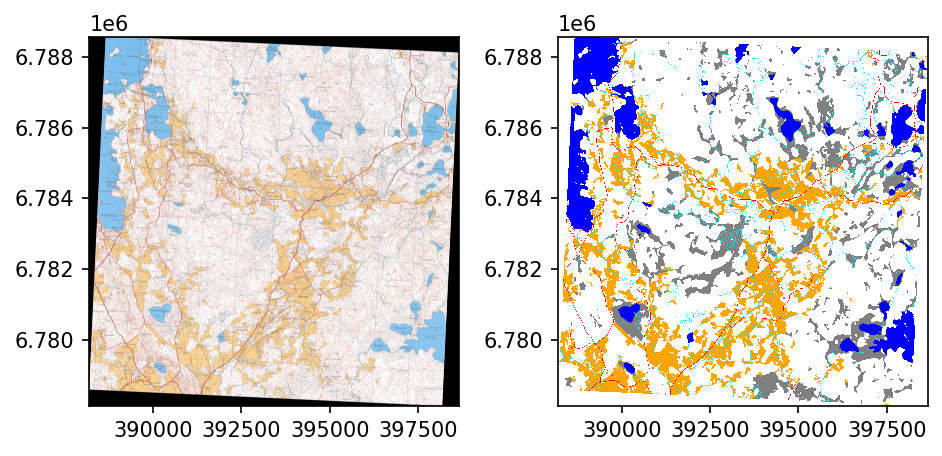

In [ ]:
fig, ax = plt.subplots(1,2, dpi=150)
refmap = rio.open('../data/maps/aligned_maps/213405_1965.tif')
rioplot.show(refmap, ax=ax[0])
refmap.close()
refmask = rio.open('../data/reference_masks/combined_mask_1965.tif')
rioplot.show(refmask, ax=ax[1], cmap=cmap, vmin=0, vmax=5, interpolation='none')
refmask.close()
plt.tight_layout()
plt.show()

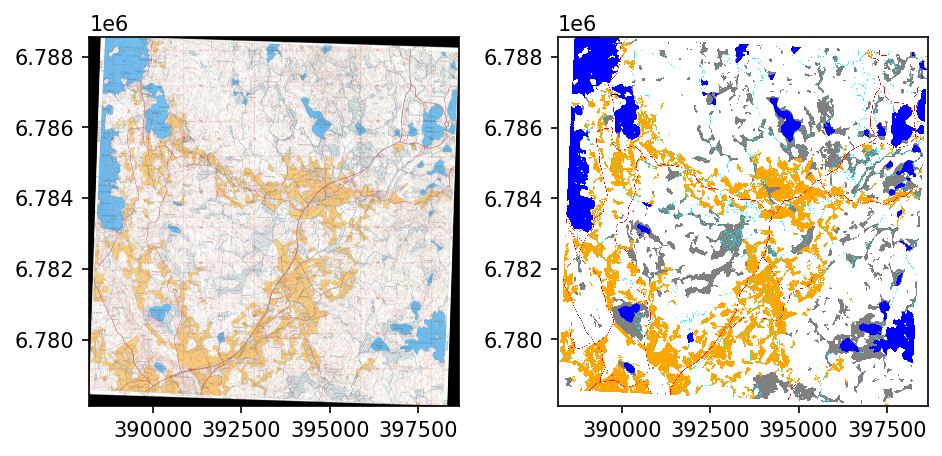

In [ ]:
fig, ax = plt.subplots(1,2, dpi=150)
refmap = rio.open('../data/maps/aligned_maps/213405_1984.tif')
rioplot.show(refmap, ax=ax[0])
refmap.close()
refmask = rio.open('../data/reference_masks/combined_mask_1965.tif')
rioplot.show(refmask, ax=ax[1], cmap=cmap, vmin=0, vmax=5, interpolation='none')
refmask.close()
plt.tight_layout()
plt.show()

# Tile masks and reference map

Use around half of the map as training and validation data and rest as test data.

In [ ]:
from rasterio.windows import Window

In [ ]:
years = ['1965', '1984']

Resulting georeferenced images are 6167x6167 pixels, so with 256x256 pixel images, 24x24 grid can be extracted.

Split tiles in 75:25 ratio such that eastern 24x16 grid is used as training data and western 8x24 is used as validation data.

In [ ]:
for year in years:
    with rio.open(f'../data/reference_masks/combined_mask_{year}.tif') as src:
        trainwin = Window.from_slices((0, 256*24), (0, 256*16))
        valwin = Window.from_slices((0, 256*24), (256*16, 256*24))
        orig_prof = src.profile
        prof = src.profile
        prof.update({
            'height': trainwin.height,
            'width': trainwin.width,
            'transform': rio.windows.transform(trainwin, src.transform)
        })
        with rio.open(f'../data/reference_masks/train_mask_{year}.tif', 'w', **prof) as dst:
            dst.write(src.read(window=trainwin))
        
        prof = src.profile
        prof.update({
            'height': valwin.height,
            'width': valwin.width,
            'transform': rio.windows.transform(valwin, src.transform)
        })
        with rio.open(f'../data/reference_masks/val_mask_{year}.tif', 'w', **prof) as dst:
            dst.write(src.read(window=valwin))
            
    with rio.open(f'../data/maps/aligned_maps/213405_{year}.tif') as src:
        trainwin = Window.from_slices((0, 256*24), (0, 256*16))
        valwin = Window.from_slices((0, 256*24), (256*16, 256*24))
        prof = src.profile
        prof.update({
            'height': trainwin.height,
            'width': trainwin.width,
            'transform': rio.windows.transform(trainwin, src.transform)
        })
        with rio.open(f'../data/reference_masks/train_im_{year}.tif', 'w', **prof) as dst:
            dst.write(src.read(window=trainwin))
        
        prof = src.profile
        prof.update({
            'height': valwin.height,
            'width': valwin.width,
            'transform': rio.windows.transform(valwin, src.transform)
        })
        with rio.open(f'../data/reference_masks/val_im_{year}.tif', 'w', **prof) as dst:
            dst.write(src.read(window=valwin))

Tile our training data and validation data, using `Tiler` from [drone_detector](https://github.com/mayrajeo/drone_detector/) package.

In [ ]:
from drone_detector.processing.tiling import Tiler
import random

In [ ]:
for year in years:
    tilesize = 256
    outpath = Path(f'../data/processed/train/{year}')
    trainmap_fn = f'../data/reference_masks/train_im_{year}.tif'
    trainmask_fn = f'../data/reference_masks/train_mask_{year}.tif'
    map_tiler = Tiler(outpath=outpath, gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    map_tiler.tile_raster(trainmap_fn)
    map_tiler.raster_path = outpath/'mask_tiles'
    map_tiler.tile_raster(trainmask_fn)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Top row is from 1965 and bottom is same patch id from 1984.

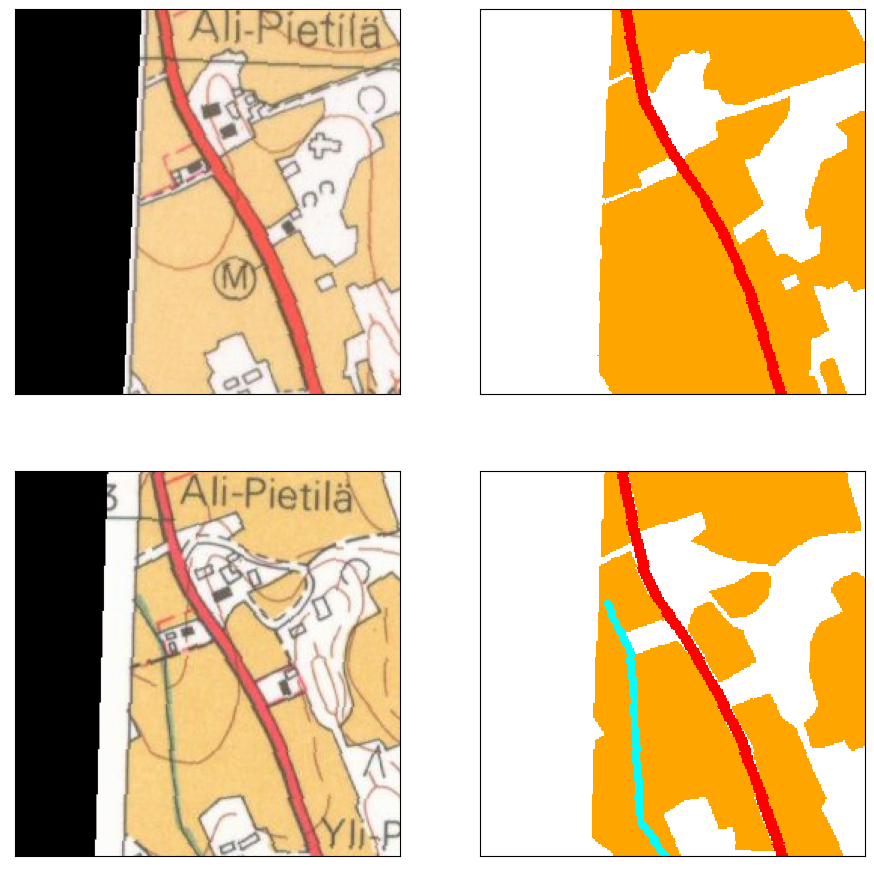

In [ ]:
ex_file = random.sample(os.listdir('../data/processed/train/1965/raster_tiles/'), 1)[0]
fig, axs = plt.subplots(2,2, figsize=(11,11))
for a in axs.flatten():
    a.set_xticks([])
    a.set_yticks([])
with rio.open(f"../data/processed/train/1965/raster_tiles/{ex_file}") as im:
    rioplot.show(im, ax=axs[0,0])
with rio.open(f"../data/processed/train/1965/mask_tiles/{ex_file}") as mask:
    rioplot.show(mask, ax=axs[0,1], cmap=cmap, interpolation='none', vmin=0, vmax=5)
    maskvals = mask.read()

with rio.open(f"../data/processed/train/1984/raster_tiles/{ex_file}") as im:
    rioplot.show(im, ax=axs[1,0])
with rio.open(f"../data/processed/train/1984/mask_tiles/{ex_file}") as mask:
    rioplot.show(mask, ax=axs[1,1], cmap=cmap, interpolation='none', vmin=0, vmax=5)
    maskvals = mask.read()

In [ ]:
for year in years:
    tilesize = 256
    outpath = Path(f'../data/processed/val/{year}')
    valmap_fn = f'../data/reference_masks/val_im_{year}.tif'
    valmask_fn = f'../data/reference_masks/val_mask_{year}.tif'
    map_tiler = Tiler(outpath=outpath, gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    map_tiler.tile_raster(valmap_fn)
    map_tiler.raster_path = outpath/'mask_tiles'
    map_tiler.tile_raster(valmask_fn)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

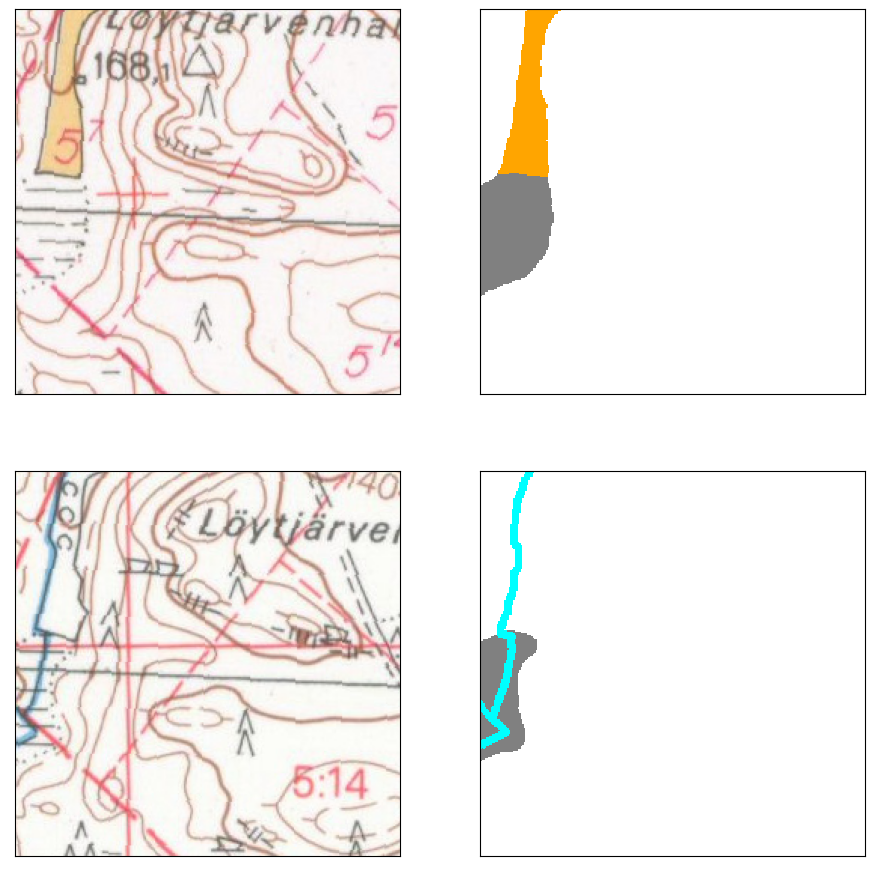

In [ ]:
ex_file = random.sample(os.listdir('../data/processed/val/1965/raster_tiles/'), 1)[0]
fig, axs = plt.subplots(2,2, figsize=(11,11))
for a in axs.flatten():
    a.set_xticks([])
    a.set_yticks([])
with rio.open(f"../data/processed/val/1965/raster_tiles/{ex_file}") as im:
    rioplot.show(im, ax=axs[0,0])
with rio.open(f"../data/processed/val/1965/mask_tiles/{ex_file}") as mask:
    rioplot.show(mask, ax=axs[0,1], cmap=cmap, interpolation='none', vmin=0, vmax=5)
    maskvals = mask.read()

with rio.open(f"../data/processed/val/1984/raster_tiles/{ex_file}") as im:
    rioplot.show(im, ax=axs[1,0])
with rio.open(f"../data/processed/val/1984/mask_tiles/{ex_file}") as mask:
    rioplot.show(mask, ax=axs[1,1], cmap=cmap, interpolation='none', vmin=0, vmax=5)
    maskvals = mask.read()